# Imports

In [1]:
import numpy as np
import os
import sys
import tensorflow as tf

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
import PIL.Image

## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
sys.path.append('/home/nauris/Dropbox/coding/models/research/')
sys.path.append('/home/nauris/Dropbox/coding/models/research/object_detection/')


from utils import label_map_util
from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
fine_tune_model = ("/home/nauris/Dropbox/coding/Valopaat/model/ssd_mobilenet_v1_coco_2017_11_17/"
                   "hand_inference_graph/frozen_inference_graph.pb")

# fine_tune_model = ("/home/nauris/Dropbox/coding/Valopaat/model/ssd_mobilenet_v1_coco_2017_11_17/"
#                    "frozen_inference_graph.pb")


PATH_TO_LABELS = ("/home/nauris/Dropbox/coding/Valopaat/data/tf_data/labels.pbtxt")

# PATH_TO_LABELS = ("/home/nauris/Dropbox/coding/udacity_self_driving/Skycar-System-Integration/"
#                   "object_detection/mscoco_label_map.pbtxt")

CKPT = fine_tune_model
NUM_CLASSES = 100

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
    od_graph_def = tf.GraphDef()

    with tf.gfile.GFile(CKPT, 'rb') as fid:

        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Hand'}}


## Helper code

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

# Detection

In [8]:
from glob import glob

In [9]:
PATH_TO_TEST_IMAGES_DIR = '/home/nauris/Dropbox/coding/Valopaat/data/img_samples/'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpeg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpeg'))  # PNG OR JPG
#TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

/home/nauris/Dropbox/coding/Valopaat/data/img_samples/*.jpeg
Length of test images: 3


(1, 725, 570, 3) uint8
Time in milliseconds 1019.0424919128418


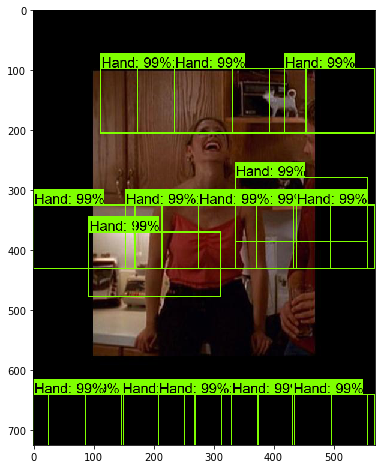

(1, 400, 713, 3) uint8
Time in milliseconds 10.507345199584961


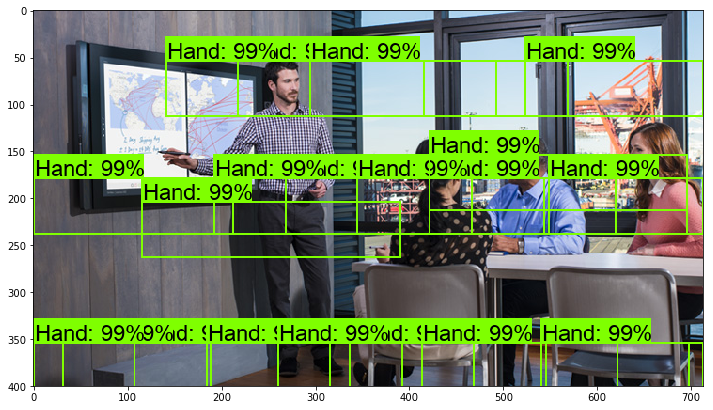

(1, 275, 183, 3) uint8
Time in milliseconds 8.944034576416016


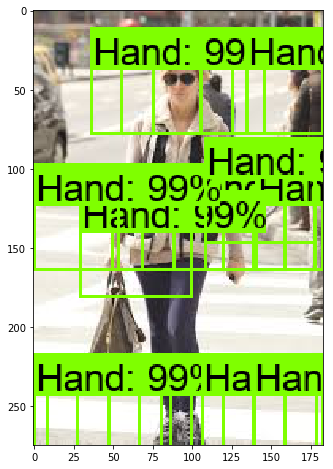

In [10]:
import time

with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
        image = PIL.Image.open(image_path)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
        # image_np = image_np[::2, ::2, :]

        # image_np = cv2.resize(image_np, (150, 100))
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)

        print(image_np_expanded.shape, image_np_expanded.dtype)

        time0 = time.time()

        # Actual detection.
        (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})

        time1 = time.time()

        print("Time in milliseconds", (time1 - time0) * 1000)

        boxes = np.squeeze(boxes)
        classes = np.squeeze(classes).astype(np.int32)
        scores = np.squeeze(scores)

        # scores[:] = 0.9
        # print(scores)

        # _scores = scores.copy()
        # boxes = boxes[(classes == 10) & (_scores > 0.8)]
        # scores = scores[(classes == 10) & (_scores > 0.8)]
        # classes = classes[(classes == 10) & (_scores > 0.8)]

        # Visualization of the results of a detection.
        im_vis = image_np.copy()
        vis_util.visualize_boxes_and_labels_on_image_array(
          im_vis,
          boxes,
          classes,
          scores,
          category_index,
          use_normalized_coordinates=True,
          line_thickness=2)
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(im_vis)
        plt.show()